In [2]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [3]:
### Dask client
client = Client(n_workers=8)
display(client)

### Generate new session
db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34759,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:38409,Total threads: 1
Dashboard: /proxy/38529/status,Memory: 7.50 GiB
Nanny: tcp://127.0.0.1:42735,


### ACCESS-OM2

In [4]:
yr_beg = '2400-02-01'
yr_end = '2449-12-31'
expt = '1deg_jra55_ryf_cont'
var = 'temp_global_ave'
frequency = '1 daily'
access_gat_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()
# [:-1] removes the snapshot at 2500-01-01 for annual average purposes

expt = '1deg_jra55_ryf_cool_x1'
var = 'temp_global_ave'
frequency = '1 daily'
access_gat_cool = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_warm_x1'
var = 'temp_global_ave'
frequency = '1 daily'
access_gat_warm = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

In [5]:
# SST
yr_beg = '2400-01-02'
yr_end = '2449-12-31'
expt = '1deg_jra55_ryf_cont'
var = 'temp_surface_ave'
access_sst_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].groupby('time.year').mean('time').load()
# [:-1] removes the snapshot at 2500-01-01 for annual average purposes

expt = '1deg_jra55_ryf_cool_x1'
var = 'temp_surface_ave'
access_sst_cool = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].groupby('time.year').mean('time').load()

expt = '1deg_jra55_ryf_warm_x1'
var = 'temp_surface_ave'
access_sst_warm = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].groupby('time.year').mean('time').load()

### 1D model

In [6]:
# Constants, data, parameters

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
# gamma = 1 / (100*86400)
kappa = 5e-6
mu = 1/(5 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz / 2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

# Analytical steady state, cf. Appendix 1

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (i.e., need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top / bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking for simplicity 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top / bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e., evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e., evaluated at the top / bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T


### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        ACCESS_ave_depth = 3642
        
        OHC[i] = z_b / ACCESS_ave_depth * np.mean(T[:, i]) # This is for average temperature
        
    return OHC


### Yearly average in order to plot on same time axes as ACCESS experiments

def onedim_yearly_ave(depth_ave_temp):
    
    time_steps_per_year = np.int(depth_ave_temp[1 : ].shape[0] / years)
    
    return np.array([np.mean(depth_ave_temp[time_steps_per_year * i : time_steps_per_year * (i + 1)]) for i in range(years)])

In [7]:
### Run experiment

years = 50
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q = np.append(0, np.zeros(int(years * 360 / days)))
T0 = np.append(0, np.zeros(int(years * 360 / days)))
onedim_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q, T0, years)

# Step function perturbation

Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

onedim_cool = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, - Q, - T0, years)
onedim_warm = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q, T0, years)

onedim_cont_gat = OHC(onedim_cont)
onedim_cool_gat = OHC(onedim_cool)
onedim_warm_gat = OHC(onedim_warm)

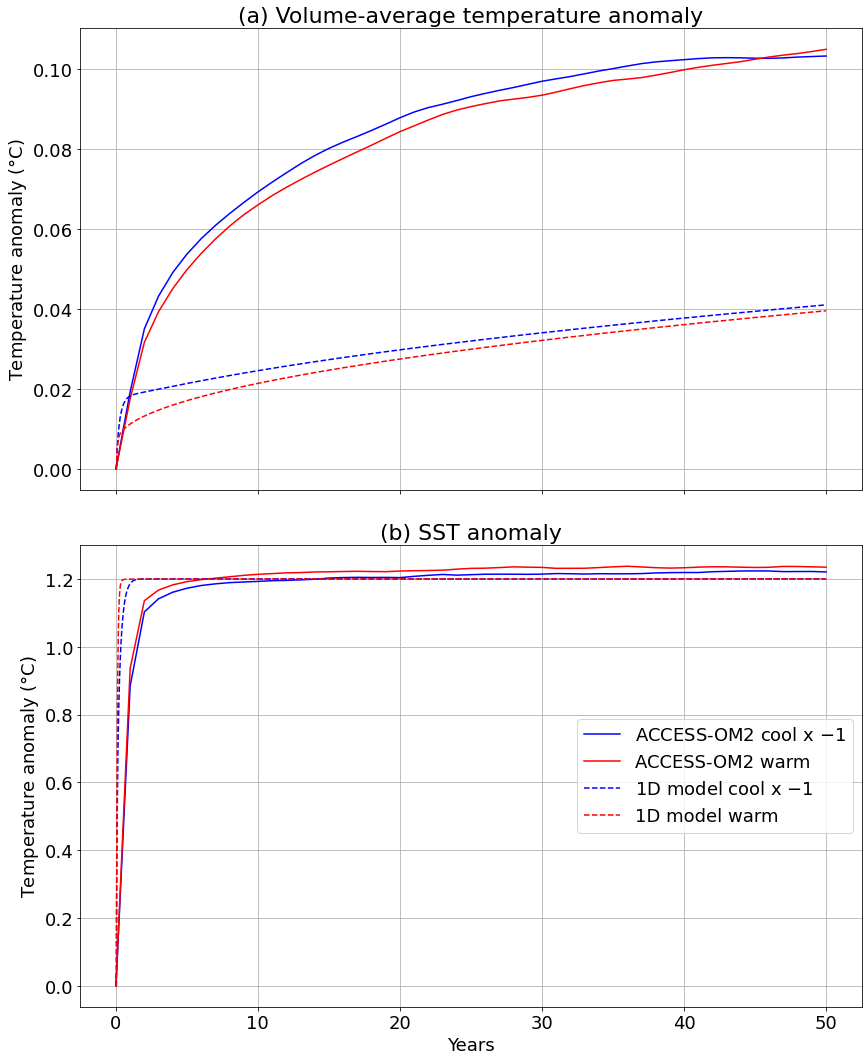

In [33]:
### Plot both ACCESS and 1D model volume-average temperatures and SSTs

### Time axis for 1D model arrays
timesteps = onedim_cont.shape[1]
length = (timesteps - 1) * days / 360
time_years = np.linspace(0,length,timesteps)
###

# fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (21,7))
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(14,18), sharex=True)
fontsize=18


ax = axs[0]
ax.plot(- 1 * np.append(0,(access_gat_cool - access_gat_cont).values.flatten())[:51], color='b', label='ACCESS-OM2 cool x $-1$')
ax.plot(np.append(0,(access_gat_warm - access_gat_cont).values.flatten())[:51], color='r', label='ACCESS-OM2 warm')
ax.plot(time_years, - 1 * (onedim_cool_gat - onedim_cont_gat), color='b', label='1D model cool x $-1$', linestyle='--')
ax.plot(time_years, (onedim_warm_gat - onedim_cont_gat), color='r', label='1D model warm', linestyle='--')
ax.set_title('(a) Volume-average temperature anomaly', fontsize = fontsize+4)
ax.set_ylabel('Temperature anomaly ($\degree$C)', fontsize = fontsize)
ax.tick_params(labelsize=fontsize)
# ax.set_xlabel('Years', fontsize = fontsize)
ax.grid()

ax = axs[1]
ax.plot(- 1 * np.append(0,(access_sst_cool - access_sst_cont).values.flatten()), color='b', label='ACCESS-OM2 cool x $-1$')
ax.plot(np.append(0,(access_sst_warm - access_sst_cont).values.flatten()), color='r', label='ACCESS-OM2 warm')
ax.plot(time_years, -1 * (onedim_cool - onedim_cont)[0,:], color='b', label='1D model cool x $-1$', linestyle='--')
ax.plot(time_years, (onedim_warm - onedim_cont)[0,:], color='r',label='1D model warm', linestyle='--')
ax.grid()
ax.set_title('(b) SST anomaly', fontsize = fontsize+4)
ax.set_ylabel('Temperature anomaly ($\degree$C)', fontsize = fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('Years',fontsize = fontsize)
ax.legend(fontsize=fontsize, loc='center right')

plt.subplots_adjust(wspace=0, hspace=0.12)

plt.savefig('Fig4.pdf', bbox_inches='tight', dpi=300)